# Imports

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import Compose, Normalize, ToTensor
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

# Load data

In [145]:
mnist_train = datasets.MNIST('.', train=True, transform=Compose([ToTensor()]), download=True)
mnist_test = datasets.MNIST('.', train=False, transform=Compose([ToTensor()]), download=True)

train_loader = DataLoader(mnist_train, batch_size=60, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=100, shuffle=False)

# Loss functions

In [27]:
class MSE_Loss():
  def __init__(self):
    pass

  def __call__(self, a, y):
    if a.shape != y.shape:
      y = self.vectorize(a.shape[0], y)
    m = y.shape[1]
    return (1 / m) * 0.5 * np.sum((a - y) ** 2)

  def backward(self, a, y):
    if a.shape != y.shape:
      y = self.vectorize(a.shape[0], y)
    m = y.shape[1]
    self.loss = self(a, y)
    return (1 / m) * (a - y)

  def item(self):
    return self.loss

  def vectorize(self, num_classes, y):
    """Convert scalar i to 10 dimensional vector with value 1 at i-th index. In case when mse_loss is used for classification task """

    y_vectorized = np.zeros((num_classes, y.shape[0]))
    for i, y_ in enumerate(y):
      y_vectorized[y_][i] = 1

    return y_vectorized

class BCE_Loss():
  def __init__(self):
    pass

  def __call__(self, z, y):
    if z.shape != y.shape:
      y = self.vectorize(z.shape[0], y)
    m = y.shape[1]
    return (1 / m) * np.sum(np.maximum(z, 0) - z * y + np.log(1 + np.exp(- np.abs(z))))

  def backward(self, z, y):
    if z.shape != y.shape:
      y = self.vectorize(z.shape[0], y)
    m = y.shape[1]
    self.loss = self(z, y)
    return (1 / m) * (Sigmoid()(z) - y)

  def item(self):
    return self.loss

  def vectorize(self, num_classes, y):
    """Convert scalar i to 10 dimensional vector with value 1 at i-th index. In case when mse_loss is used for classification task """

    y_vectorized = np.zeros((num_classes, y.shape[0]))
    for i, y_ in enumerate(y):
      y_vectorized[y_][i] = 1

    return y_vectorized

# Activation functions

In [5]:
class Sigmoid():
  def __init__(self):
    pass

  def __call__(self, x):
    self.z_prev = x
    self.a = 1 / (1 + np.exp(-x))

    return self.a

  def backward(self, grad):
    self.grad = grad * self.a * (1 - self.a)
    return self.grad

  def __str__(self):
    return 'activation'

# Layers

In [6]:
class Linear():
  def __init__(self, input_size, output_size):
    self.w = np.random.randn(output_size, input_size) * np.sqrt(2 / input_size)
    self.b = np.random.randn(output_size, 1)

  def __call__(self, x):
    """x: input with shape (input_size, batch_size). Returns linear transformation x@w+b with shape (output_size, batch_size)"""
    self.prev_a = x
    self.z = self.w @ self.prev_a + self.b

    return self.z

  def backward(self, grad):
    self.grad_w = grad @ self.prev_a.T
    self.grad_b = grad.sum(axis=1, keepdims=True)

    self.grad = self.w.T @ grad

    return self.grad

  def update_params(self, lr):
    self.w -= lr * self.grad_w
    self.b -= lr * self.grad_b

  def __str__(self):
    return 'linear'

# ANN

In [7]:
np.random.seed(23)
class ANN():
  def __init__(self, layers):
    self.layers = layers

    self.num_layers = len(layers)

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)

    return x

  def backward(self, grad):
    for layer in self.layers[::-1]:
      grad = layer.backward(grad)

  def update_params(self, lr=1e-4):
    for layer in self.layers:
      if str(layer) != 'activation':
        layer.update_params(lr)

# Model training

In [146]:
ann = ANN([
           Linear(784, 256),
           Sigmoid(),
           Linear(256, 10)
          #  Sigmoid()
])
# loss_fn = MSE_Loss()
loss_fn = BCE_Loss()

In [147]:
epochs = 20
train_loss = []
train_acc = []
val_loss = []
val_acc = []
lr = 3e-1
sigmoid = Sigmoid()

for epoch in range(epochs):
  running_loss = 0.
  total = 0.
  correct = 0
  for i, (x, y) in enumerate(tqdm(train_loader), 1):
    x = x.reshape(x.shape[0], -1).numpy()
    y = y.numpy()

    out = ann(x.T)
    loss = loss_fn.backward(out, y)
    ann.backward(loss)
    ann.update_params(lr)

    running_loss += loss_fn.item()
    total += y.shape[0]
    correct += (sigmoid(out.T).argmax(axis=1) == y).sum()

    if i % 250 == 0:
      print(f'Iter: {i} - Loss: {running_loss / i}')
  train_loss.append(running_loss / len(train_loader))
  train_acc.append(correct / total)

  running_loss = 0.
  total = 0.
  correct = 0
  for i, (x, y) in enumerate(tqdm(test_loader), 1):
    x = x.reshape(x.shape[0], -1).numpy()
    y = y.numpy()

    out = ann(x.T)
    loss = loss_fn(out, y)

    running_loss += loss
    total += y.shape[0]
    correct += (sigmoid(out.T).argmax(axis=1) == y).sum()
  val_loss.append(running_loss / len(test_loader))
  val_acc.append(correct / total)

  print(f'Epoch: {epoch+1} - Loss: {train_loss[-1]} - Accuracy {train_acc[-1]} - Val Loss: {val_loss[-1]} - Val Accuracy: {val_acc[-1]}')

Iter: 250 - Loss: 1.6023060789606045
Iter: 500 - Loss: 1.214749567370349
Iter: 750 - Loss: 1.0526945804832148
Iter: 1000 - Loss: 0.9548467644754008




Epoch: 1 - Loss: 0.9548467644754008 - Accuracy 0.8551 - Val Loss: 0.5942928793185065 - Val Accuracy: 0.9153


Iter: 250 - Loss: 0.6166539632366229
Iter: 500 - Loss: 0.5899858106785774
Iter: 750 - Loss: 0.5678817962914204
Iter: 1000 - Loss: 0.5517250434004386




Epoch: 2 - Loss: 0.5517250434004386 - Accuracy 0.92065 - Val Loss: 0.46006297900960297 - Val Accuracy: 0.9337


Iter: 250 - Loss: 0.4586289904182007
Iter: 500 - Loss: 0.4530427254989386
Iter: 750 - Loss: 0.4481894726907262
Iter: 1000 - Loss: 0.4350504562163852




Epoch: 3 - Loss: 0.4350504562163852 - Accuracy 0.9381833333333334 - Val Loss: 0.38888266579394837 - Val Accuracy: 0.9457


Iter: 250 - Loss: 0.3879046103609346
Iter: 500 - Loss: 0.3772969523408942
Iter: 750 - Loss: 0.3674887392564869
Iter: 1000 - Loss: 0.3622055367942654




Epoch: 4 - Loss: 0.3622055367942654 - Accuracy 0.9487333333333333 - Val Loss: 0.33156764181280285 - Val Accuracy: 0.9521


Iter: 250 - Loss: 0.32003839990076516
Iter: 500 - Loss: 0.3213181789962318
Iter: 750 - Loss: 0.31404934636912957
Iter: 1000 - Loss: 0.31047486192212315




Epoch: 5 - Loss: 0.31047486192212315 - Accuracy 0.9562666666666667 - Val Loss: 0.29251384566840993 - Val Accuracy: 0.9586


Iter: 250 - Loss: 0.2864439795465317
Iter: 500 - Loss: 0.28318188686814566
Iter: 750 - Loss: 0.27640632438696516
Iter: 1000 - Loss: 0.2725404479340315




Epoch: 6 - Loss: 0.2725404479340315 - Accuracy 0.9624333333333334 - Val Loss: 0.2707501742468777 - Val Accuracy: 0.9626


Iter: 250 - Loss: 0.2455561550761612
Iter: 500 - Loss: 0.24406383742565227
Iter: 750 - Loss: 0.2431879692824362
Iter: 1000 - Loss: 0.24309129963492832




Epoch: 7 - Loss: 0.24309129963492832 - Accuracy 0.96675 - Val Loss: 0.2412897750012836 - Val Accuracy: 0.9661


Iter: 250 - Loss: 0.21397717470770153
Iter: 500 - Loss: 0.21884061351608475
Iter: 750 - Loss: 0.22030372143797097
Iter: 1000 - Loss: 0.21941382526292472




Epoch: 8 - Loss: 0.21941382526292472 - Accuracy 0.9708666666666667 - Val Loss: 0.22648652025505406 - Val Accuracy: 0.9677


Iter: 250 - Loss: 0.20644088698963148
Iter: 500 - Loss: 0.2092928652794568
Iter: 750 - Loss: 0.2055208115785775
Iter: 1000 - Loss: 0.2007901192042831




Epoch: 9 - Loss: 0.2007901192042831 - Accuracy 0.9733 - Val Loss: 0.21136653356571988 - Val Accuracy: 0.9709


Iter: 250 - Loss: 0.181448309424511
Iter: 500 - Loss: 0.18340727055391337
Iter: 750 - Loss: 0.18246203483373047
Iter: 1000 - Loss: 0.18405165802921059




Epoch: 10 - Loss: 0.18405165802921059 - Accuracy 0.9756333333333334 - Val Loss: 0.2054409862500214 - Val Accuracy: 0.9708


Iter: 250 - Loss: 0.1714782530852924
Iter: 500 - Loss: 0.16990108714500235
Iter: 750 - Loss: 0.1668950546167478
Iter: 1000 - Loss: 0.17079338458772356




Epoch: 11 - Loss: 0.17079338458772356 - Accuracy 0.9778833333333333 - Val Loss: 0.19178332306098855 - Val Accuracy: 0.9736


Iter: 250 - Loss: 0.15376761169109593
Iter: 500 - Loss: 0.1517064542788611
Iter: 750 - Loss: 0.15852125069369236
Iter: 1000 - Loss: 0.15913344192748913




Epoch: 12 - Loss: 0.15913344192748913 - Accuracy 0.9791166666666666 - Val Loss: 0.1846710704799125 - Val Accuracy: 0.9741


Iter: 250 - Loss: 0.1474076109407034
Iter: 500 - Loss: 0.14895287475391547
Iter: 750 - Loss: 0.14948092632160564
Iter: 1000 - Loss: 0.14835842685610937




Epoch: 13 - Loss: 0.14835842685610937 - Accuracy 0.9814166666666667 - Val Loss: 0.17690577717618464 - Val Accuracy: 0.9744


Iter: 250 - Loss: 0.1311078659379011
Iter: 500 - Loss: 0.1366151981775356
Iter: 750 - Loss: 0.13883463508243246
Iter: 1000 - Loss: 0.13879042572333133




Epoch: 14 - Loss: 0.13879042572333133 - Accuracy 0.98245 - Val Loss: 0.17042377429161415 - Val Accuracy: 0.9758


Iter: 250 - Loss: 0.12876456510625167
Iter: 500 - Loss: 0.13372807664845468
Iter: 750 - Loss: 0.13227434117128603
Iter: 1000 - Loss: 0.13067848802389453




Epoch: 15 - Loss: 0.13067848802389453 - Accuracy 0.9835166666666667 - Val Loss: 0.16367452627208073 - Val Accuracy: 0.9776


Iter: 250 - Loss: 0.12246502677580177
Iter: 500 - Loss: 0.12540159622438357
Iter: 750 - Loss: 0.12254264794298762
Iter: 1000 - Loss: 0.12292609462473855




Epoch: 16 - Loss: 0.12292609462473855 - Accuracy 0.9850333333333333 - Val Loss: 0.1596761776854693 - Val Accuracy: 0.9776


Iter: 250 - Loss: 0.11482004087838259
Iter: 500 - Loss: 0.11697789884549495
Iter: 750 - Loss: 0.11587820710300002
Iter: 1000 - Loss: 0.11561325711129707




Epoch: 17 - Loss: 0.11561325711129707 - Accuracy 0.98595 - Val Loss: 0.15993340239899723 - Val Accuracy: 0.9769


Iter: 250 - Loss: 0.10947024404248483
Iter: 500 - Loss: 0.10989839558471408
Iter: 750 - Loss: 0.109554800676559
Iter: 1000 - Loss: 0.10976611374380173




Epoch: 18 - Loss: 0.10976611374380173 - Accuracy 0.9873 - Val Loss: 0.157481903789472 - Val Accuracy: 0.9777


Iter: 250 - Loss: 0.10078067270175642
Iter: 500 - Loss: 0.10239790587604049
Iter: 750 - Loss: 0.10246397983850875
Iter: 1000 - Loss: 0.10366267114657743




Epoch: 19 - Loss: 0.10366267114657743 - Accuracy 0.9882666666666666 - Val Loss: 0.15686924218444678 - Val Accuracy: 0.9782


Iter: 250 - Loss: 0.09183301761704811
Iter: 500 - Loss: 0.09672123679010348
Iter: 750 - Loss: 0.0976842894472619
Iter: 1000 - Loss: 0.09870668399531982




Epoch: 20 - Loss: 0.09870668399531982 - Accuracy 0.9887333333333334 - Val Loss: 0.14901531398459902 - Val Accuracy: 0.978


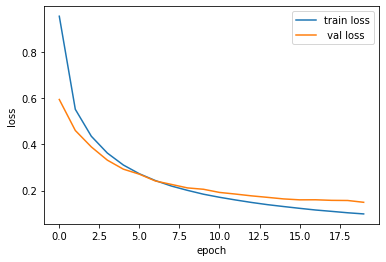

In [148]:
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label=' val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

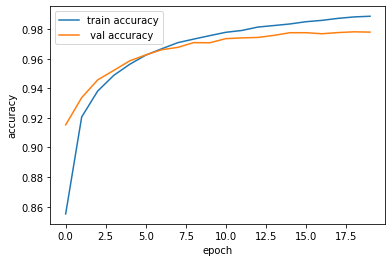

In [149]:
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label=' val accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

# Make predictions

In [215]:
test_loader = DataLoader(mnist_test, batch_size=100, shuffle=False)
total = 0.
correct = 0.
preds = []
true = []
for x, y in tqdm(test_loader):
  x = x.reshape(x.shape[0], -1).numpy()
  y = y.numpy()

  out = ann(x.T)
  total += y.shape[0]
  preds.append(sigmoid(out.T).argmax(axis=1))
  true.append(y)
  correct += (sigmoid(out.T).argmax(axis=1) == y).sum()
correct / total

0.978

In [216]:
preds = np.concatenate(preds)
true = np.concatenate(true)

Text(33.0, 0.5, 'True')

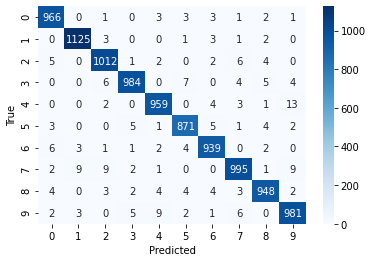

In [227]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true, preds)
sns.heatmap(cm, cmap=plt.cm.Blues, fmt='d', annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')